In [1]:
import datetime
import calendar
import dateutil.parser as parser
from dateutil.relativedelta import relativedelta
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import os, sys, glob
import kaleido
from PIL import Image
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
now = datetime.now()

In [3]:
def convert_date(utc_time): 
    parsed_date = parser.parse(utc_time)
    var_date=parsed_date.date()
    var_time=parsed_date.time()
    var_weekday=parsed_date.weekday()
    var_weekday_name=calendar.day_name[parsed_date.weekday()]
    return var_date, var_time, var_weekday ,var_weekday_name

In [4]:
def viz(data, indice):
    fig = go.Figure(data=[go.Candlestick(x=data['UTC_Time'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False,
                      title="Neighbor: " + indice + " " + " " + now.strftime("%Y-%m-%d %H:%M:%S"),
                      title_font_color="blue",
                      title_font_size = 20)
    
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])
    
    fig.write_image(path + "/" + indice + "_chart.png")
    
    fig.show()

In [5]:
def chart(data):
    fig = go.Figure(data=[go.Candlestick(x=data['UTC_Time'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    
    fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])

    fig.show()

In [6]:
currency_pairs = ["EUR_USD"]
filename = "EUR_USD.csv"

### Logging

In [7]:
now = datetime.now()
for pair in currency_pairs:
    Log_Folder = now.strftime("%d-%m-%Y_%I-%M_%p")
    path = os.path.join(Log_Folder+"_"+pair)
    os.mkdir(path)

# Load Candlestick Dataset

In [8]:
data = pd.read_csv('EUR_USD_H4.csv')

# Feature Engineering

In [9]:
data['O-H'] = data['Open'] - data['High']
data['O-L'] = data['Open'] - data['Low']
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['H-C'] = data['High'] - data['Close']
data['L-C'] = data['Low'] - data['Close']

data['Direction'] = data['O-C'].apply(lambda x: 1 if x<0 else 0)

data['col_1'] = data['Open'] - data['Close']

for value in data['col_1']:   
    if value > 0:
        data['col_2'] = data['High'] - data['Open']
        data['col_3'] = data['Close'] - data['Low']
    else:
        data['col_2'] = data['High'] - data['Close']
        data['col_3'] = data['Open'] - data['Low']

#Two Previous Candlesticks 
data['col_4'] = data['col_1'].shift(1)
data['col_5'] = data['col_1'].shift(2)

#Moving Avarage
data['SMA_10'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=10).mean()

#Feature Engineering Moving Avarage 
data['F_SMA_10'] = data['Close'] - data['SMA_10']
data['F_SMA_20'] = data['Close'] - data['SMA_20']

In [10]:
data = data.dropna()

In [11]:
data = data.to_csv(filename, header = True, index = False)

# <font color='red'>CANDLE INDEX NUMBER</font>

In [24]:
data = pd.read_csv(filename)

In [25]:
candle_no = len(data) - 999

In [26]:
data = data.iloc[candle_no:candle_no+30]

In [27]:
chart(data)

# Modeling

In [28]:
data = pd.read_csv(filename)

### Feature Selection and Reduction

In [29]:
data = data.drop(columns=['Volume','Weekday','Date','Time',
                          'Weekday_Name','UTC_Time','Direction',
                          'Open', 'High', 'Low', 'Close',
                          'O-H','O-L','O-C','H-L','H-C','L-C',
                          'SMA_10','SMA_20',
#                          'col_1','col_2','col_3',
                          'col_4','col_5',
#                          'F_SMA_10','F_SMA_20'
                         ])

# Comment out the features that you want to fit into your model.

In [30]:
data.head()

,col_1,col_2,col_3,F_SMA_10,F_SMA_20
0,-0.00005,0.00028,0.00107,0.001294,0.001884
1,0.00272,0.00575,0.00275,-0.001186,-0.000077
2,0.00030,0.00380,0.00130,-0.001698,-0.000395
3,-0.00417,0.00103,0.00077,0.002110,0.003298
4,0.00004,0.00101,0.00116,0.001816,0.002677


In [31]:
def find_k_similar_candles(candle_id, dataset, k=4):
    indices=[]
    distances = []
    output = []
    model_knn = NearestNeighbors(metric = 'euclidean', algorithm = 'auto') 
    model_knn.fit(dataset)
    
    #metric = 'euclidean' or 'cosine' or 'manhattan' or 'mahalanobis'
    
    distances, indices = model_knn.kneighbors(dataset.iloc[candle_id,:].values.reshape(1,-1),
                                              n_neighbors = k)

    for i in range(0,len(distances.flatten())):
        if i==0:
            display (pd.DataFrame(data.iloc[candle_id]).transpose())
            #print("Recommendation for {0}:\n".format(eurusd_data.index[candle_id]))
        else:
            #print("{0}: {1}, with distance of {2}".format(i,
            #                                               dataset.index[indices.flatten()[i]],
            #                                               distances.flatten()[i]))
            
            output.append ([dataset.index[indices.flatten()[i]],
                            distances.flatten()[i],
#                           dataset.iloc[indices.flatten()[i]]['O-H'],dataset.iloc[indices.flatten()[i]]['O-L'],dataset.iloc[indices.flatten()[i]]['O-C'],dataset.iloc[indices.flatten()[i]]['H-L'],dataset.iloc[indices.flatten()[i]]['H-C'],dataset.iloc[indices.flatten()[i]]['L-C'],
                           dataset.iloc[indices.flatten()[i]]['col_1'],dataset.iloc[indices.flatten()[i]]['col_2'],dataset.iloc[indices.flatten()[i]]['col_3'],
#                           dataset.iloc[indices.flatten()[i]]['col_4'],dataset.iloc[indices.flatten()[i]]['col_5'],
                           dataset.iloc[indices.flatten()[i]]['F_SMA_10'],dataset.iloc[indices.flatten()[i]]['F_SMA_20'],
                           ])
    
    output = pd.DataFrame(output)
    output.columns = ['Indice','Distance',
#                      'O-H','O-L','O-C','H-L','H-C','L-C',
                      'col_1','col_2','col_3',
#                      'col_4','col_5',
                      'F_SMA_10','F_SMA_20'
                     ]
    display (output)
    
    return indices, distances

### Top 5 Similar Candlesticks

In [32]:
indices, distances = find_k_similar_candles (candle_no,data)

,col_1,col_2,col_3,F_SMA_10,F_SMA_20
8654,-0.00114,0.00033,0.00004,0.004558,0.004702


,Indice,Distance,col_1,col_2,col_3,F_SMA_10,F_SMA_20
0,5414,0.000540,-0.00135,0.00023,0.00012,0.004368,0.005143
1,10,0.000877,-0.00072,0.00082,0.00032,0.004060,0.004863
2,8901,0.000916,-0.00167,0.00001,0.00023,0.004178,0.005227


In [33]:
indices = indices[0:1][0]

### Recommendations

Neighbor: 5414 |


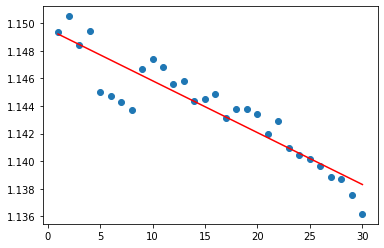

"Goodness of Fit" is 85.0 %
SELL
Neighbor: 10 |


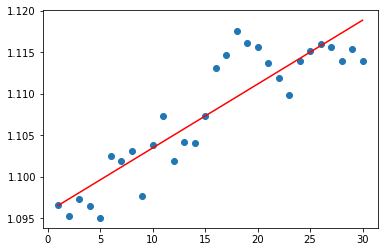

"Goodness of Fit" is 80.0 %
BUY
Neighbor: 8901 |


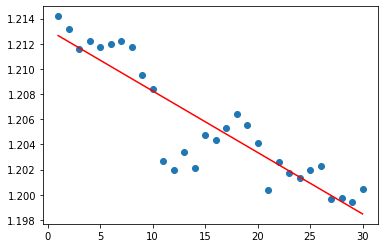

"Goodness of Fit" is 81.0 %
SELL


In [34]:
for indice in indices[1:10]:
    recommendation_log = "{}_data.csv".format(indice)
    data = pd.read_csv(filename) 
    data = data.iloc[indice:indice+30]
    data.to_csv(path + "/" + recommendation_log, header = True, index = False)
    
    print ('Neighbor:', indice, '|')
    viz(data, indice.astype(str))
    
    data['candleno'] = range (1, len(data) + 1)
    X = data['candleno'].values.reshape(-1, 1)
    Y = data['Close'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    y_pred = linear_regressor.predict(X)
    plt.scatter(X, Y)
    plt.plot(X, y_pred, color='red')
    plt.show()
    
    print('"Goodness of Fit" is', r2_score(Y, y_pred).round(2)*100, '%')
    coeficient = (linear_regressor.coef_)
    
    if coeficient > 0:
        print('BUY')
    else:
        print('SELL')



In [23]:
currentpath = os.path.join(sys.path[0])
pngfiles = []
pngfiles = glob.glob(currentpath+"/"+path+"/*.png")
pdf = FPDF()

for pngfile in pngfiles:
    pdf.add_page()
    pdf.image(pngfile, w=200, h=130)
    
pdf.output(path+"/recommendations.pdf", "F")

''